# Project 3 for CSE142
## CIFAR-10 Classification

Importing necessary packages:

- tensorflow/keras: API to build and train models
- matplotlib: generate graphs
- numpy: perform array operations
- pandas: to work with dataframes
- pickle: for serializing and de-serializing a Python object
- os: for file paths

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import numpy as np
import pandas as pd
# import pickle
# import os, os.path

### *Initialize relevant variables*

In [2]:
labels_df = pd.read_csv("Semi1_Labels.csv") #change this for different versions
train_path = 'Train_Image' 
test_path = 'Test_Image' 
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
labels_df

,Train Label
0,NAN
1,dog
2,NAN
3,airplane
4,NAN
...,...
9995,NAN
9996,NAN
9997,airplane
9998,NAN


## Defining some functions

In [3]:
def get_image(img_number):
    img = mpimg.imread(train_path + f"/{img_number}.png") 
    return img
def get_test_image(img_number):
    img = mpimg.imread(test_path + f"/{img_number}.png") 
    return img
def get_label(arr):
    max_index_col = np.argmax(arr, axis=0)
    return labels[max_index_col]

In [4]:
# plt.imshow(get_image(7777))

In [5]:
# plt.imshow(get_test_image(999))

**Function that prints image info**

In [6]:
def get_img_info(img):
    rows,cols,channels = img.shape 
    img_size = rows*cols*channels # channels means rgb colors i think, so should always be 3?
    img_to_1D = img.reshape(img_size) #numPy reshape
    print("rows, cols, channels:", rows, cols, channels)
    print("image size:", img_size)
#     print("image original:", img)
#     print("image reshape:", img_to_1D)
#     return img_to_1D

In [7]:
# get_img_info(get_image(3)) 

## Preprocessing the  Data

We need to separate the labeled data from the unlabeled

Also need to encode labels as numbers instead of strings

In [8]:
#is_unlabelled = labels_df["Train Label"] == NAN
labelled = (labels_df["Train Label"]!= "NAN")
unlabelled = (labels_df["Train Label"] == "NAN")

unlabelled_data = (labels_df[unlabelled])
print(unlabelled_data)

labelled_data = (labels_df[labelled])
print(labelled_data)

     Train Label
0            NAN
2            NAN
4            NAN
5            NAN
6            NAN
...          ...
9994         NAN
9995         NAN
9996         NAN
9998         NAN
9999         NAN

[8000 rows x 1 columns]
     Train Label
1            dog
3       airplane
8           deer
18          frog
26          deer
...          ...
9977        deer
9988        frog
9990  automobile
9992        bird
9997    airplane

[2000 rows x 1 columns]


In [9]:
labeled = []
unlabeled = []

labeled = labelled_data["Train Label"].tolist()
unlabeled = unlabelled_data["Train Label"].tolist()

# print (labeled) 
# print (unlabeled) 

In [10]:
#col = labels_df.columns
#for i, entry in enumerate(labels_df[col[0]]):
 #   if (entry == 'NAN'):
  #      unlabeled.append(i)
   # else:
   #     labeled.append([i, entry])
# print("labeled", labeled)
# print("unlabeled", unlabeled)


2000


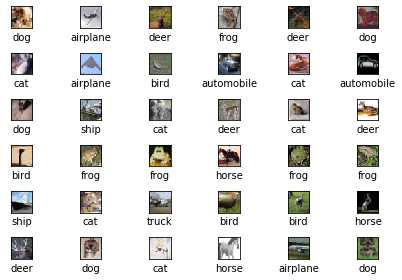

In [11]:
# Need to reshape training data and labels
train_images, train_labels, test_images, test_labels = [], [], [], []
for i in labelled_data.iterrows():
    train_images.append(get_image(i[0]))
    train_labels.append(i[1]['Train Label'])
print(len(train_images))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(train_labels[i])
plt.show()

### TODO: One-Hot Encoding

In [12]:
#change this to one-hot
for i in range(len(train_labels)):
    for j in range(len(labels)):
        if train_labels[i] == labels[j]:
            train_labels[i] = j
# print (train_labels)

In [13]:
#split labeled data so that we have some labeled testing data 80/20
test_images =  np.array(train_images[1600:])
train_images = np.array(train_images[:1600])
test_labels = np.array(train_labels[1600:])
train_labels = np.array(train_labels[:1600])
print(len(train_images), len(train_labels), len(test_images), len(test_labels))


1600 1600 400 400


## Baseline Model

### Convolutional Neural Network

As input, a CNN takes tensors of shape (height, width, channels) = (32, 32, 3)

This is based on https://www.tensorflow.org/tutorials/images/cnn

In [14]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [15]:
#Is this stopping too soon?
callback1 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=3, restore_best_weights=True)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) 



In [16]:
history = model.fit(train_images, train_labels, epochs=100, 
                    validation_data=(test_images, test_labels), callbacks=[callback2])

Train on 1600 samples, validate on 400 samples
Epoch 1/100
1600/1600 [==============================] - 2s 1ms/sample - loss: 2.2637 - accuracy: 0.1675 - val_loss: 2.1711 - val_accuracy: 0.2100
Epoch 2/100
1600/1600 [==============================] - 1s 657us/sample - loss: 2.0599 - accuracy: 0.2562 - val_loss: 1.9005 - val_accuracy: 0.2825
Epoch 3/100
1600/1600 [==============================] - 1s 654us/sample - loss: 1.8516 - accuracy: 0.3388 - val_loss: 1.7462 - val_accuracy: 0.4100
Epoch 4/100
1600/1600 [==============================] - 1s 640us/sample - loss: 1.7111 - accuracy: 0.3919 - val_loss: 1.6916 - val_accuracy: 0.4000
Epoch 5/100
1600/1600 [==============================] - 1s 640us/sample - loss: 1.5966 - accuracy: 0.4300 - val_loss: 1.7286 - val_accuracy: 0.3775
Epoch 6/100
1600/1600 [==============================] - 1s 636us/sample - loss: 1.5599 - accuracy: 0.4437 - val_loss: 1.7360 - val_accuracy: 0.3725
Epoch 7/100
1600/1600 [==============================] - 1s 6

## Augmenting the Model



### Label some of our unlabeled data

In [17]:
new_labels = [];
new_images = [];

for j,i in enumerate(unlabelled_data.iterrows()):
    if j < 500:
        new_images.append(get_image(i[0]))
#         print(i[0])


predictions = model.predict(np.array(new_images))
for i in predictions:
    new_labels.append(get_label(i))
    
print(len(new_images), len(new_labels))

500 500


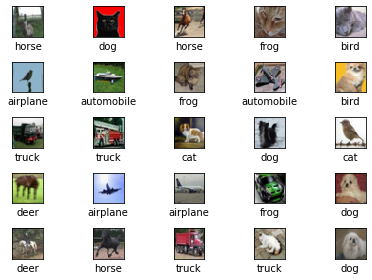

In [18]:
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.grid(False)
    plt.imshow(new_images[i])
    plt.xlabel(new_labels[i])
plt.show()

In [19]:
new_train_images = np.concatenate((train_images, new_images), axis=0)
new_train_labels = np.concatenate((train_labels, new_labels), axis=0)

for i in range(len(new_train_labels)):
    for j in range(len(labels)):
        if new_train_labels[i] == labels[j]:
            new_train_labels[i] = j
            
new_train_labels = tf.strings.to_number(new_train_labels)
            
print(len(new_train_images),len(new_train_labels))

print(new_train_labels, train_labels)


2100 2100
tf.Tensor([5. 0. 4. ... 6. 6. 4.], shape=(2100,), dtype=float32) [5 0 4 ... 7 3 0]


In [20]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(10))
model2.summary()

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) 

history2 = model2.fit(new_train_images, new_train_labels, epochs=100, 
                    validation_data=(test_images, test_labels), callbacks=[callback1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

## ResNet 50 

As per TA recommendation

In [21]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


In [22]:
resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(32,32,3))

In [23]:
augmented_model = tf.keras.Sequential([
resnet,
# layers.Flatten(),
# layers.Dense(64, activation='relu'),
layers.Dense(10)
])

In [24]:
augmented_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 1, 1, 10)          20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [25]:
augmented_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = augmented_model.fit(train_images, train_labels, epochs=20, 
                    validation_data=(test_images, test_labels))

Train on 1600 samples, validate on 400 samples
Epoch 1/20
 256/1600 [===>..........................] - ETA: 1:39 - loss: 3.4599 - accuracy: 0.1034

KeyboardInterrupt: 

# Predictions


**Preliminary predictions on the test images using just the supervised part**

It is not very accurate

In [ ]:
test_image = []
for i in range(25):
    test_image.append(get_test_image(i))
    
predictions = model.predict(np.array(test_image))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.grid(False)
    plt.imshow(get_test_image(i))
    plt.xlabel(get_label(predictions[i]))
plt.show()